## Convert SST data to same resolution as CHL data and save for each subarea

In [ ]:
!python --version

Python 3.9.16


In [1]:
# import all necessary libraries
import os
from datetime import datetime, timedelta
import getpass
import xarray as xr
!python -m pip install motuclient==1.8.4 --no-cache-dir 
import motuclient
import xarray as xr
import numpy as np
!python -m pip install ffmpeg==1.4
import matplotlib.pyplot as plt
import matplotlib
import subprocess
import pandas as pd
!python -m pip install rioxarray
import rioxarray
import rasterio as rio
import rasterio.plot
!python -m pip install netCDF4
import netCDF4
!python -m pip install h5netcdf
import h5netcdf 
import random
from skimage import io as skio
import ffmpeg
import matplotlib.gridspec as gridspec
import subprocess
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#from numba import jit, cuda
import tifffile
from tqdm import tqdm
import skimage.transform as sktransform
import tensorflow as tf
!pip install dask==2022.12.1
import dask
from dask.graph_manipulation import bind, wait_on

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for motuclient: filename=motuclient-1.8.4-py3-none-any.whl size=32873 sha256=076ff025931b2e4676772909a8e94ff350bffc12c9f294d9ba5be2487b8ff87e
  Stored in directory: /tmp/pip-ephem-wheel-cache-qdyobmbo/wheels/46/74/d1/ee3216f52d83212f10a0a5f5b94f3d99cf3d29b8ecf09c60b6
Successfully built motuclient
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=6322cf0cc0ce111680af3aab8886451713b9cd9ae161181f43326d451014411a
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
chl_dir = r'/content/drive/MyDrive/MasterThesis/Data/CHL_1km'
sst_dir = r'/content/drive/MyDrive/MasterThesis/Data/SSTemp'
mask_dir = r'/content/drive/MyDrive/MasterThesis/Data/land_mask/iowtopo2_rev03.nc'

data_dir_RIGA = r'/content/drive/MyDrive/MasterThesis/Data_preprocessing/GulfofRiga'
data_dir_KTT = r'/content/drive/MyDrive/MasterThesis/Data_preprocessing/Kattegat'
data_dir_GTL = r'/content/drive/MyDrive/MasterThesis/Data_preprocessing/Gotland'

In [4]:
riga_range_x  = range(720,880,1)
riga_range_y = range(330,490,1)

kattegat_range_x  = range(50,210,1)
kattegat_range_y = range(200,360,1)

gotland_range_x  = range(470,630,1)
gotland_range_y = range(160,320,1)

## CHL data and mask data to x and y

In [7]:
mask_data= xr.open_dataset(f"{mask_dir}")
mask_data = mask_data.rename_dims({'XT_I': 'x', 'YT_J': 'y'}).rename_vars({"XT_I": "x", "YT_J": "y"}).set_coords(["x", "y"])
chl_data = xr.open_mfdataset(f"{chl_dir}/CHL_data_"+"*.nc", decode_coords="all")
chl_data = chl_data.sel(time=~chl_data.get_index("time").duplicated())
chl_data = chl_data.rename_dims({'lon': 'x', 'lat': 'y'}).rename_vars({"lon": "x", "lat": "y"}).set_coords(["x", "y"])
chl_data_temp = chl_data.isel(time=0)

Exception ignored in: <function CachingFileManager.__del__ at 0x7f624be35ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/xarray/backends/file_manager.py", line 248, in __del__
  File "/usr/local/lib/python3.10/dist-packages/xarray/backends/file_manager.py", line 232, in close
  File "/usr/local/lib/python3.10/dist-packages/scipy/io/_netcdf.py", line 313, in close
OSError: [Errno 107] Transport endpoint is not connected


In [8]:
# Resample the smaller dataset to match the dimensions of the larger dataset
mask_data_resampled = mask_data.interp_like(chl_data_temp, method='nearest')

# Close the datasets
mask_data.close()
chl_data.close()
mask_data_resampled.close()

### Gulf of Riga

In [9]:
chl_data_RIGA = chl_data.isel(x=riga_range_x, y= riga_range_y)
static_data_RIGA = mask_data_resampled.isel(x=riga_range_x, y= riga_range_y)
static_data_RIGA

<xarray.Dataset>
Dimensions:    (x: 160, bnds: 2, y: 160)
Coordinates:
  * x          (x) float32 22.02 22.04 22.05 22.07 ... 24.78 24.8 24.82 24.84
  * y          (y) float32 56.88 56.89 56.9 56.91 ... 58.59 58.61 58.62 58.63
Dimensions without coordinates: bnds
Data variables: (12/14)
    XT_I_bnds  (x, bnds) float64 22.0 22.03 22.03 22.07 ... 24.83 24.83 24.87
    YT_J_bnds  (y, bnds) float64 56.87 56.88 56.88 56.9 ... 58.62 58.62 58.63
    Z_TOPO     (y, x) float32 41.4 40.5 40.5 49.1 49.1 ... 29.9 32.8 32.8 34.1
    Z_WATER    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Z_LAND     (y, x) float32 41.4 40.5 40.5 49.1 49.1 ... 29.9 32.8 32.8 34.1
    Z_MIN      (y, x) float32 37.0 33.0 33.0 47.0 47.0 ... 26.0 27.0 27.0 30.0
    ...         ...
    Z_NEAR     (y, x) float32 44.0 36.0 36.0 52.0 52.0 ... 34.0 38.0 38.0 35.0
    D_NEAR     (y, x) float32 0.5275 0.5275 0.5275 ... 0.5218 0.5218 0.5219
    N_WET      (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    N_DRY      (y, x) float32 8.0 8.0 8.0 8.0 8.0 8.0 ... 8.0 8.0 8.0 8.0 8.0
    LANDMASK   (y, x) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    FLAG       (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    history:  Thu Jun 21 18:41:58 2007: ncks -A -a -x -v Z_TOPO,Z_WATER /silo...
    title:    IOW Baltic Sea Topography

In [10]:
# extract values 
landmask_RIGA_array = static_data_RIGA['LANDMASK'].values
topo_RIGA_array = static_data_RIGA["Z_TOPO"].values

In [11]:
# save data in directory
np.save(f'{data_dir_RIGA}/landmask.npy', landmask_RIGA_array)
np.save(f'{data_dir_RIGA}/topo.npy', topo_RIGA_array)

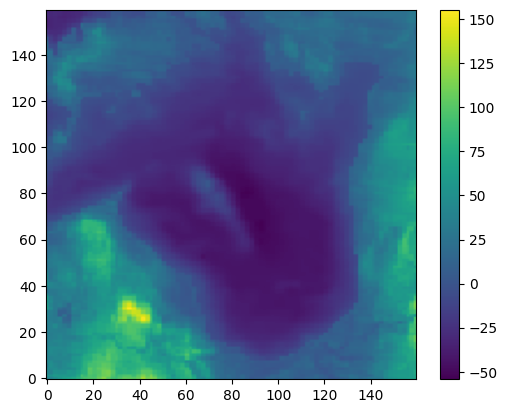

In [12]:
plt.figure()
plt.imshow(topo_RIGA_array, origin='lower')
plt.colorbar()
plt.show()

In [14]:
# write data into pd dataframe
df_chl_RIGA = chl_data_RIGA.to_dataframe()
df_chl_RIGA = df_chl_RIGA.reset_index(drop=False)
df_chl_RIGA

In [ ]:
landmask_RIGA_array = np.repeat(landmask_RIGA_array[np.newaxis, :, :], 2071, axis=0)
topo_RIGA_array = np.repeat(topo_RIGA_array[np.newaxis, :, :], 2071, axis=0)
# combine the dataframes on columns 'A' and 'B', and repeat df2 if necessary
df_chl_RIGA['landmask'] = landmask_RIGA_array.flatten()
df_chl_RIGA['topo'] = topo_RIGA_array.flatten()
df_chl_RIGA

In [ ]:
df_chl_RIGA.to_csv(f"{data_dir_RIGA}/chl_data.csv", index=False)

### Gotland Basin

In [17]:
chl_data_GTL = chl_data.isel(x=gotland_range_x, y= gotland_range_y)
static_data_GTL = mask_data_resampled.isel(x=gotland_range_x, y= gotland_range_y)

In [18]:
# extract values 
landmask_GTL_array = static_data_GTL['LANDMASK'].values
topo_GTL_array = static_data_GTL["Z_TOPO"].values

In [19]:
# save data in directory
np.save(f'{data_dir_GTL}/landmask.npy', landmask_GTL_array)
np.save(f'{data_dir_GTL}/topo.npy', topo_GTL_array)

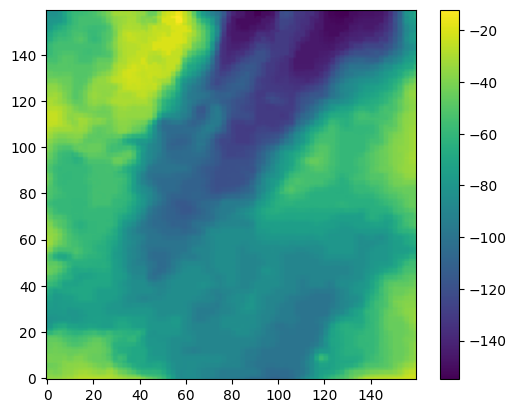

In [20]:
plt.figure()
plt.imshow(topo_GTL_array, origin='lower')
plt.colorbar()
plt.show()

### Kattegat

In [21]:
chl_data_KTT = chl_data.isel(x=kattegat_range_x, y= kattegat_range_y)
static_data_KTT = mask_data_resampled.isel(x=kattegat_range_x, y= kattegat_range_y)

In [22]:
# extract values 
landmask_KTT_array = static_data_KTT['LANDMASK'].values
topo_KTT_array = static_data_KTT["Z_TOPO"].values

In [23]:
# save data in directory
np.save(f'{data_dir_KTT}/landmask.npy', landmask_KTT_array)
np.save(f'{data_dir_KTT}/topo.npy', topo_KTT_array)

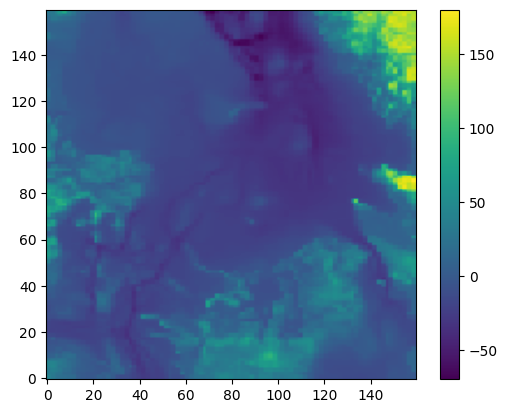

In [24]:
plt.figure()
plt.imshow(topo_KTT_array, origin='lower')
plt.colorbar()
plt.show()

### SST Data


In [27]:
sst_data = xr.open_mfdataset(f"{sst_dir}/SST_data_"+"*.nc", combine='by_coords')
sst_data = sst_data.chunk(chunks={'lon':160, 'lat':160, 'time':2})
sst_data = sst_data.resample(time='1D').mean('time')

<xarray.Dataset>
Dimensions:       (lat: 630, lon: 1038, time: 2549)
Coordinates:
  * lat           (lat) float32 53.26 53.28 53.3 53.32 ... 65.8 65.82 65.84
  * lon           (lon) float32 9.26 9.28 9.3 9.32 ... 29.94 29.96 29.98 30.0
  * time          (time) datetime64[ns] 2016-04-30 2016-05-01 ... 2023-04-22
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(1, 160, 160), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                CF-1.4, Unidata Observation Dataset v1.0
    title:                      Baltic Sea - SST Analysis
    summary:                    DMI Sea Surface Temperature analysis created ...
    references:                 Høyer, J. L. and She, J., Optimal interpolati...
    institution:                Danish Meteorological Institute, DMI
    history:                    Version 1.0
    ...                         ...
    comment:                    IN NO EVENT SHALL DMI OR ITS REPRESENTATIVES ...
    History:                    Translated to CF-1.0 Conventions by Netcdf-Ja...
    geospatial_lat_min:         53.2599983215332
    geospatial_lat_max:         65.83999633789062
    geospatial_lon_min:         9.25999927520752
    geospatial_lon_max:         30.0

In [28]:
sst_data = sst_data.sel(time=slice('2016-04-30', '2023-04-22'))

In [29]:
# Resample the smaller dataset to match the dimensions of the larger dataset
sst_data = sst_data.sel(time=~sst_data.get_index("time").duplicated())
sst_data = sst_data.rename_dims({'lon': 'x', 'lat': 'y'}).rename_vars({"lon": "x", "lat": "y"}).set_coords(["x", "y"])
lat_lon_subset = chl_data[['x', 'y']]
sst_data_resampled = sst_data.interp_like(lat_lon_subset, method='nearest')
sst_data_resampled

<xarray.Dataset>
Dimensions:       (time: 2549, y: 1147, x: 1185)
Coordinates:
  * time          (time) datetime64[ns] 2016-04-30 2016-05-01 ... 2023-04-22
  * y             (y) float32 53.26 53.27 53.28 53.29 ... 65.82 65.83 65.84
  * x             (x) float32 9.259 9.277 9.294 9.312 ... 30.21 30.22 30.24
Data variables:
    analysed_sst  (time, y, x) float32 dask.array<chunksize=(1, 1147, 1185), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                CF-1.4, Unidata Observation Dataset v1.0
    title:                      Baltic Sea - SST Analysis
    summary:                    DMI Sea Surface Temperature analysis created ...
    references:                 Høyer, J. L. and She, J., Optimal interpolati...
    institution:                Danish Meteorological Institute, DMI
    history:                    Version 1.0
    ...                         ...
    comment:                    IN NO EVENT SHALL DMI OR ITS REPRESENTATIVES ...
    History:                    Translated to CF-1.0 Conventions by Netcdf-Ja...
    geospatial_lat_min:         53.2599983215332
    geospatial_lat_max:         65.83999633789062
    geospatial_lon_min:         9.25999927520752
    geospatial_lon_max:         30.0

### Gulf of Riga

In [31]:
# cut to gulf of Riga size
sst_data_RIGA = sst_data_resampled.isel(x=riga_range_x, y= riga_range_y)

In [32]:
sst_values = sst_data_RIGA['analysed_sst'].values

In [33]:
sst_times = sst_data_RIGA.time.values

In [35]:
np.save(f'{data_dir_RIGA}/sst_values.npy', sst_values)
np.save(f'{data_dir_RIGA}/sst_time.txt', sst_times)

Kattegat

In [36]:
# cut to Kattegat size
sst_data_KTT= sst_data_resampled.isel(x=kattegat_range_x, y= kattegat_range_y)
sst_values = sst_data_KTT['analysed_sst'].values
sst_times = sst_data_KTT.time.values
np.save(f'{data_dir_KTT}/sst_values.npy', sst_values)
np.save(f'{data_dir_KTT}/sst_time.txt', sst_times)


### Gotland

In [37]:
# cut to Gotland size
sst_data_GTL= sst_data_resampled.isel(x=gotland_range_x, y= gotland_range_y)
sst_values = sst_data_GTL['analysed_sst'].values
sst_times = sst_data_GTL.time.values
np.save(f'{data_dir_GTL}/sst_values.npy', sst_values)
np.save(f'{data_dir_GTL}/sst_time.txt', sst_times)